In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'1.12.1+cpu'

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
f'Device: {device}'

'Device: cpu'

Dataset

In [8]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:3], y[:3]

(tensor([[0.0000],
         [0.0200],
         [0.0400]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280]]))

In [9]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [10]:
def plot_prediction(train_data = X_train,
                    train_labels = y_train,
                    test_data = X_test,
                    test_labels = y_test,
                    predictions = None):
    
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
    plt.legend(prop={"size": 14})

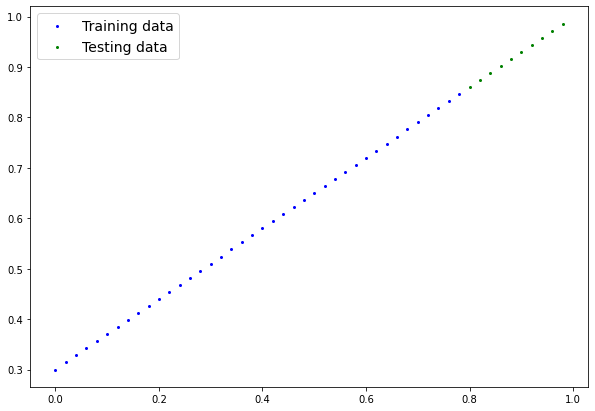

In [11]:
plot_prediction(X_train, y_train, X_test, y_test)

Pytorch Linear Model

In [61]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
    def forward(self, x):
        x = self.linear_layer(x)
        return x

In [62]:
def training_loop(model, X_test, y_test, X_train, y_train):
    EPOCHS = 200

    loss_fn = nn.L1Loss() # same as MAE
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    for epoch in range(EPOCHS):

        model.train()

        y_pred = model(X_train)

        loss = loss_fn(y_pred, y_train)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        model.eval()

        with torch.inference_mode():
            test_pred = model(X_test)
            
            test_loss = loss_fn(test_pred, y_test)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, loss = {loss}, test loss = {test_loss}')


In [63]:
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [64]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

In [65]:
model_1(X_test)

tensor([[1.4416],
        [1.4569],
        [1.4722],
        [1.4875],
        [1.5028],
        [1.5181],
        [1.5334],
        [1.5487],
        [1.5640],
        [1.5793]], grad_fn=<AddmmBackward0>)

In [66]:
training_loop(model_1, X_train, y_train, X_test, y_test)

Epoch 0, loss = 0.5874472260475159, test loss = 0.5417069792747498
Epoch 10, loss = 0.40823739767074585, test loss = 0.40699711441993713
Epoch 20, loss = 0.2290276288986206, test loss = 0.2722872495651245
Epoch 30, loss = 0.04981783777475357, test loss = 0.1375773847103119
Epoch 40, loss = 0.011269050650298595, test loss = 0.11230465024709702
Epoch 50, loss = 0.011109048500657082, test loss = 0.1115526333451271
Epoch 60, loss = 0.01094906311482191, test loss = 0.110800601541996
Epoch 70, loss = 0.010789054445922375, test loss = 0.1100485697388649
Epoch 80, loss = 0.010719060897827148, test loss = 0.10659454017877579
Epoch 90, loss = 0.010559064336121082, test loss = 0.10584249347448349
Epoch 100, loss = 0.010399073362350464, test loss = 0.10509047657251358
Epoch 110, loss = 0.010239070281386375, test loss = 0.10433845221996307
Epoch 120, loss = 0.01016907673329115, test loss = 0.10088441520929337
Epoch 130, loss = 0.010009068064391613, test loss = 0.10013239085674286
Epoch 140, loss = 

In [67]:
model_1.eval()

with torch.inference_mode():
    result = model_1(X_test)
result[:3], y_test[:3]

(tensor([[0.8783],
         [0.8888],
         [0.8992]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880]]))

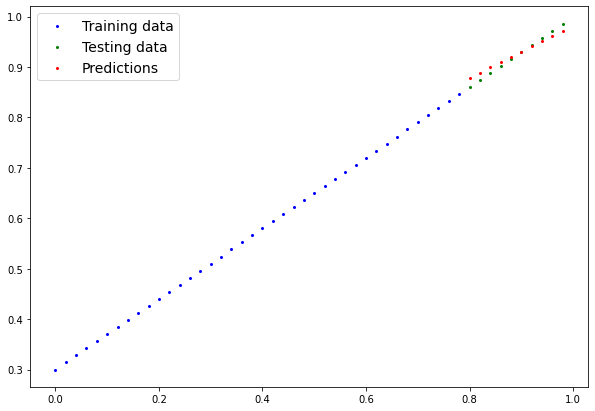

In [68]:
detached_result = result.detach()
plot_prediction(X_train, y_train, X_test, y_test, detached_result)

Save and load model

In [69]:
from pathlib import Path

MODEL_PATH = Path('MODELS')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = '01_pytorch_workflow_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(model_1.state_dict(), MODEL_SAVE_PATH)

In [70]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5204]])),
             ('linear_layer.bias', tensor([0.4620]))])

In [71]:
model_to_load = LinearRegressionModelV2()
model_to_load.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.2343]])),
             ('linear_layer.bias', tensor([0.9186]))])

In [72]:
model_to_load.load_state_dict(torch.load(MODEL_SAVE_PATH))
model_to_load.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5204]])),
             ('linear_layer.bias', tensor([0.4620]))])

In [73]:
model_to_load.eval()
with torch.inference_mode():
    loaded_pred = model_to_load(X_test)

loaded_pred == result

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])